<a href="https://colab.research.google.com/github/AbdelrahmanTamer11/Text-summarization/blob/main/Text_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
import matplotlib.pyplot as plt

In [9]:
def load_data(file_path):
    data = pd.read_csv(file_path)
    input_texts = data['Processed Text'].astype(str).values
    target_texts = data['summarizer'].astype(str).values
    return input_texts, target_texts

In [10]:
def tokenize_and_pad(input_texts, target_texts):
    input_tokenizer = Tokenizer()
    output_tokenizer = Tokenizer()

    input_tokenizer.fit_on_texts(input_texts)
    output_tokenizer.fit_on_texts(target_texts)

    input_sequences = input_tokenizer.texts_to_sequences(input_texts)
    output_sequences = output_tokenizer.texts_to_sequences(target_texts)

    max_input_len = max(len(seq) for seq in input_sequences)
    max_output_len = max(len(seq) for seq in output_sequences)

    input_sequences = pad_sequences(input_sequences, maxlen=max_input_len, padding='post')
    output_sequences = pad_sequences(output_sequences, maxlen=max_output_len, padding='post')

    return input_sequences, output_sequences, input_tokenizer, output_tokenizer, max_input_len, max_output_len


In [11]:
# Function to create the Seq2Seq model
def create_model(input_vocab_size, output_vocab_size, max_input_len, max_output_len):
    # Encoder
    encoder_inputs = Input(shape=(max_input_len,))
    encoder_embedding = Embedding(input_vocab_size, 256)(encoder_inputs)
    encoder_lstm = LSTM(256, return_state=True)
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
    encoder_states = [state_h, state_c]

    # Decoder
    decoder_inputs = Input(shape=(max_output_len,))
    decoder_embedding = Embedding(output_vocab_size, 256)(decoder_inputs)
    decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
    decoder_dense = Dense(output_vocab_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [12]:
def train_model(model, X_train, y_train):
    # Shift y_train by one timestep to align with decoder inputs
    y_train_input = y_train[:, :-1]
    y_train_output = y_train[:, 1:]

    # Pad y_train_input to match the expected shape
    y_train_input = pad_sequences(y_train_input, maxlen=max_output_len, padding='post')
    y_train_output = pad_sequences(y_train_output, maxlen=max_output_len, padding='post')


    history = model.fit([X_train, y_train_input], y_train_output,
                        batch_size=64, epochs=20, validation_split=0.2)
    return history

In [13]:
# Function to plot training history
def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.tight_layout()
    plt.show()


Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 53s 605ms/step - accuracy: 0.5141 - loss: 7.3843 - val_accuracy: 0.5439 - val_loss: 4.2492
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 84s 630ms/step - accuracy: 0.5485 - loss: 4.0898 - val_accuracy: 0.5442 - val_loss: 4.1563
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 82s 626ms/step - accuracy: 0.5437 - loss: 4.0426 - val_accuracy: 0.5477 - val_loss: 4.1399
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 87s 685ms/step - accuracy: 0.5504 - loss: 3.9639 - val_accuracy: 0.5485 - val_loss: 4.1318
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 77s 631ms/step - accuracy: 0.5511 - loss: 3.9106 - val_accuracy: 0.5491 - val_loss: 4.1169
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 87s 688ms/step - accuracy: 0.5473 - loss: 3.9016 - val_accuracy: 0.5504 - val_loss: 4.0933
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 77s 629ms/step - accuracy: 0.5552 - loss: 3.7866 - val_accuracy: 0.5522 - val_loss: 4.0624
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 82s 630ms/step - accuracy: 0.5572 - loss: 3.7149 - val_accu

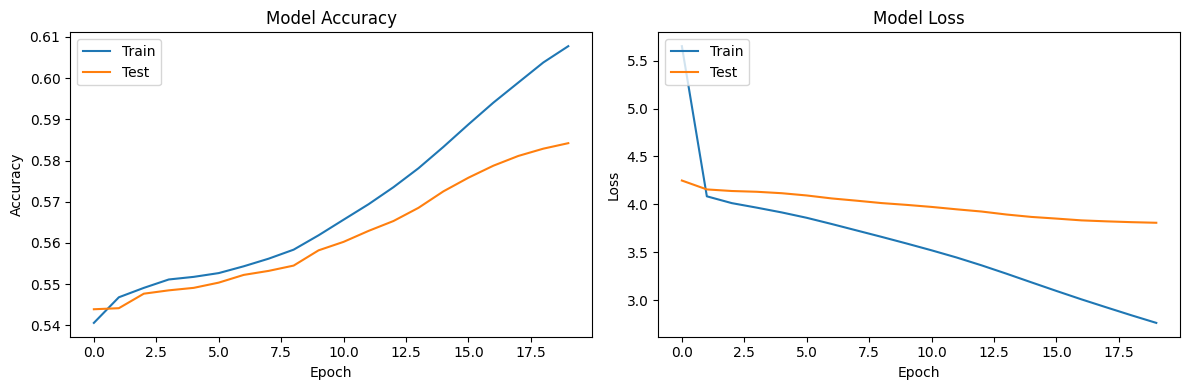

In [14]:
# Main execution
if __name__ == "__main__":
    file_path = '/content/summarizdataset.csv'
    input_texts, target_texts = load_data(file_path)
    input_sequences, output_sequences, input_tokenizer, output_tokenizer, max_input_len, max_output_len = tokenize_and_pad(input_texts, target_texts)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(input_sequences, output_sequences, test_size=0.2)

    # Get vocabulary sizes
    input_vocab_size = len(input_tokenizer.word_index) + 1
    output_vocab_size = len(output_tokenizer.word_index) + 1

    # Create and train the model
    model = create_model(input_vocab_size, output_vocab_size, max_input_len, max_output_len)
    history = train_model(model, X_train, y_train)

    # Plot training history
    plot_history(history)